In [2]:
import warnings

# Ignore UserWarning for QDA
warnings.simplefilter("ignore", UserWarning)

import os

dir = str(os.getcwd())
split_dir = dir.split('\\')

# Set the github repository directory
for folder in reversed(split_dir):
    if folder != 'AA_Project_G6' and 'AA_Project_G6' in split_dir:
        os.chdir(os.path.dirname(os.getcwd()))
    else:
        break

print('Current directory:', os.getcwd())

Current directory: c:\Users\AndreLopes\Desktop\git\AA_Project_G6


# **Data Import**

In [3]:
import pandas as pd
import numpy as np

# Import data from .csv file
df = pd.read_csv(filepath_or_buffer='./data/processed/data_processed.csv', delimiter=',')

# **Training and Testing Data Split**

In [4]:
from sklearn.model_selection import train_test_split, KFold

# Create the input and output matrices, split in training and testing subsets
y = df.copy()['Attrition_Flag_Existing Customer']
X = df.copy().drop(columns=['Attrition_Flag_Existing Customer'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# **PCA Dimension Reduction**

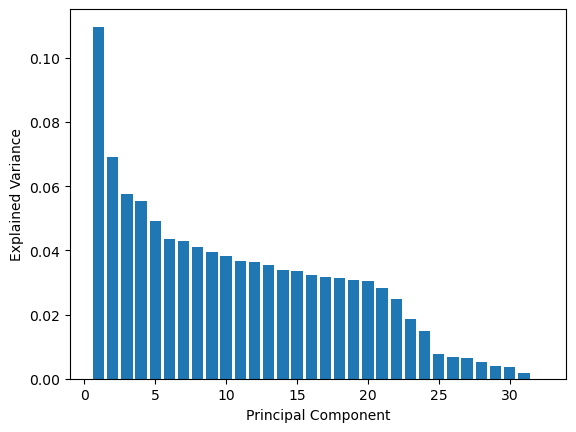

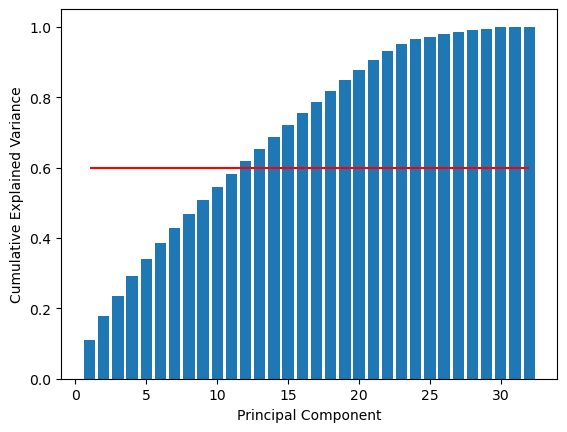

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_dr(X, n_components, verbosity):
    # If verbosity = 1, plot the explained variance
    # Data normalizing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the PCA model
    pca = PCA(n_components=n_components)

    # Fit the PCA model to the data
    pca.fit(X_scaled)

    # Transform the data to the first 3 principal components
    data_pca = pca.transform(X_scaled)

    if verbosity == 1:
        # Plot explained variance
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance")
        plt.show()

    if verbosity == 2:
        # Plot cumulative explained variance
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel("Principal Component")
        plt.ylabel("Cumulative Explained Variance")
        plt.hlines(y=0.6, xmin=1, xmax=32, colors='r')
        plt.show()
    
    return pca, data_pca

_, _ = pca_dr(X, n_components=len(X.columns), verbosity=1)
_, _ = pca_dr(X, n_components=len(X.columns), verbosity=2)

# **Support Vector Machine (SVM)**

Number of principal components: 1   Elapsed time: 2.72s    Accuracy: 84.6%
Number of principal components: 2   Elapsed time: 2.57s    Accuracy: 84.4%
Number of principal components: 3   Elapsed time: 2.91s    Accuracy: 83.55%
Number of principal components: 4   Elapsed time: 3.17s    Accuracy: 84.8%
Number of principal components: 5   Elapsed time: 3.9s    Accuracy: 83.48%
Number of principal components: 6   Elapsed time: 3.95s    Accuracy: 83.97%
Number of principal components: 7   Elapsed time: 4.74s    Accuracy: 83.78%
Number of principal components: 8   Elapsed time: 4.77s    Accuracy: 84.76%
Number of principal components: 9   Elapsed time: 5.22s    Accuracy: 86.71%
Number of principal components: 10   Elapsed time: 5.19s    Accuracy: 87.46%
Number of principal components: 11   Elapsed time: 5.6s    Accuracy: 87.1%
Number of principal components: 12   Elapsed time: 5.41s    Accuracy: 86.77%
Number of principal components: 13   Elapsed time: 6.18s    Accuracy: 86.61%
Number of prin

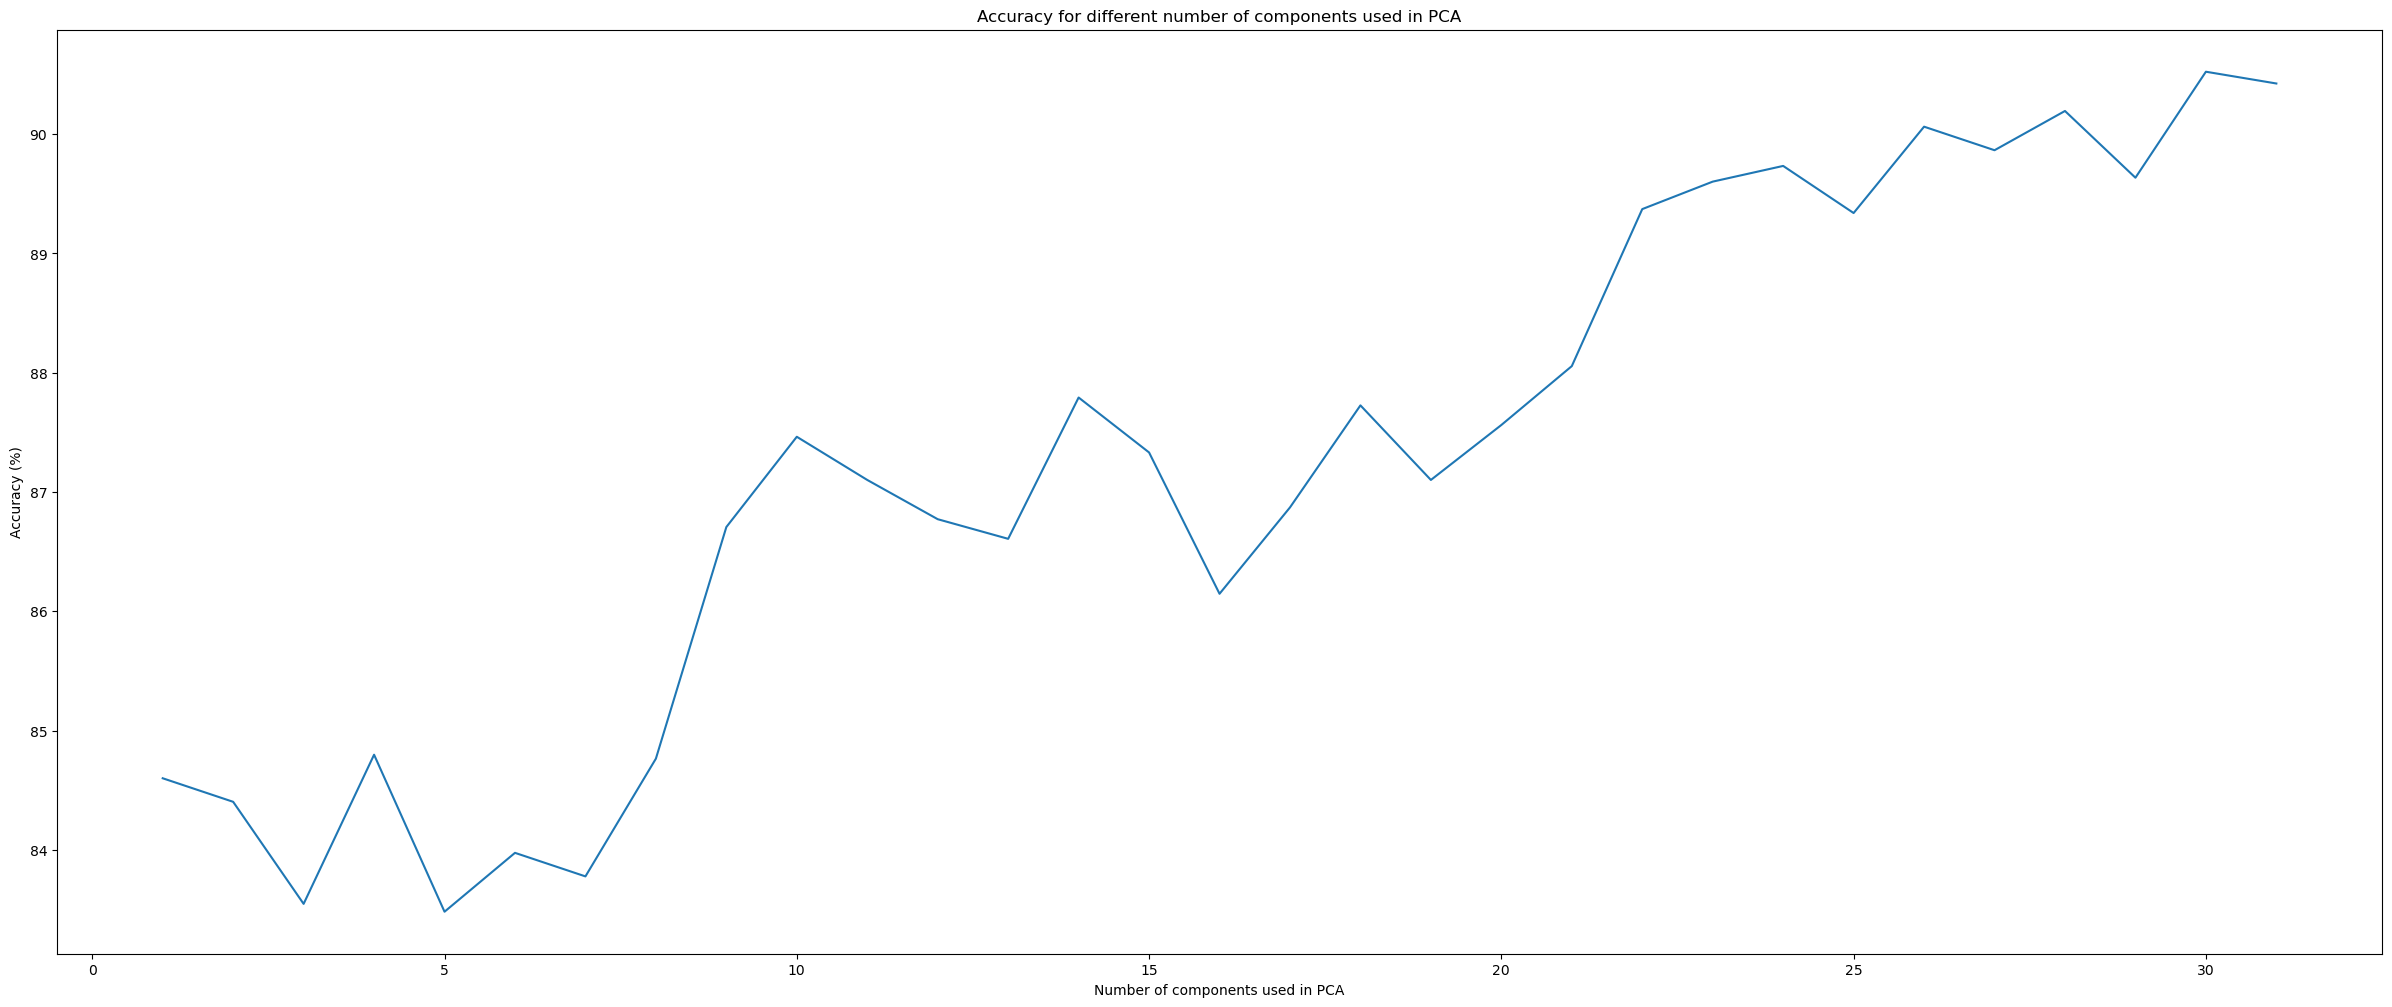

In [10]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

accuracies = []
y_svm_pred_list = []
y_svm_true_list = []

# Loop to find out how many principal components provides the best results
for i in range(len(X.columns)-1):
    start_time = time.time()

    pca, data_pca = pca_dr(X, n_components=i+1, verbosity=0)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data_pca, y, train_size=0.7)

    # Initialize the SVM model
    svm = SVC(C=1, kernel='linear', probability=True)

    # Fit the model to the training data
    svm.fit(X_train, y_train)

    # Predict the classification and print the confusion matrix
    y_pred = svm.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred)*100)

    ## Store the necessary variables for ROC/AUC
    cols_to_store = [i for i in range(len(svm.classes_)) if svm.classes_[i] == 1]
    y_svm_pred = svm.predict_proba(X_test)[:,cols_to_store]
    y_svm_pred_list.append(y_svm_pred)
    y_svm_true = (y_test.copy() == 1).copy()
    y_svm_true_list.append(y_svm_true)

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print('Number of principal components: ' + str(i+1) + '   Elapsed time: ' + str(round(elapsed_time,2)) + 's' + '    Accuracy: ' + str(round(accuracy_score(y_test, y_pred)*100,2)) + '%')

# Plot the results
plt.subplots(figsize=(30, 12))
plt.plot([i+1 for i in range(len(X.columns)-1)], accuracies)
plt.xlabel('Number of components used in PCA')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for different number of components used in PCA')
plt.show()

# Takes around 3min to compute

In [11]:
from sklearn.model_selection import GridSearchCV

# Find best number of components for PCA
max_accuracy = max(accuracies)
max_index = accuracies.index(max_accuracy)+1

pca, data_pca = pca_dr(X, n_components=21, verbosity=0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_pca, y, train_size=0.7)

In [ ]:
# Select the optimal C parameter by cross-validation for linear kernel
tuned_parameters = [{'C': [0.1, 1, 10, 100]}]
svm_linear = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy')
svm_linear.fit(X_train, y_train)

cv_results_linear = pd.DataFrame(svm_linear.cv_results_)

# Takes around 5min to compute

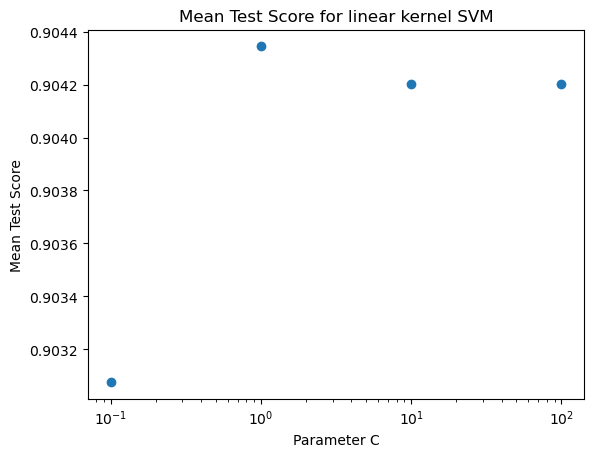

Best parameters:
C = 1
Accuracy: 90.43%


In [ ]:
fig, ax = plt.subplots()

scatter = plt.scatter(cv_results_linear['param_C'], cv_results_linear['mean_test_score'])

plt.xlabel('Parameter C')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score for linear kernel SVM')
ax.set_xscale('log')
#fig.colorbar(scatter).set_label('Accuracy Score')

plt.show()

print('Best parameters:\n' + 'C = ' + str(cv_results_linear.loc[cv_results_linear['mean_test_score'].idxmax()]['param_C']) + 
                             '\nAccuracy: ' + str(round(cv_results_linear['mean_test_score'].max()*100,2)) + '%')

In [ ]:
# Compute the best linear kernel SVM
best_linear_C = cv_results_linear['params'][np.argmax(cv_results_linear['mean_test_score'])]['C']
svm_best_linear = SVC(C=best_linear_C, kernel='linear', probability=True)

# Fit the model to the training data
svm_best_linear.fit(X_train, y_train)

# Store the necessary variables for ROC/AUC
cols_to_store = [i for i in range(len(svm_best_linear.classes_)) if svm_best_linear.classes_[i] == 1]
y_svm_best_linear_pred = svm_best_linear.predict_proba(X_test)[:,cols_to_store]
y_svm_best_linear_true = (y_test.copy() == 1).copy()

In [ ]:
# Select the optimal C and gamma parameters by cross-validation for polynomial kernel
tuned_parameters = [{'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
svm_poly = GridSearchCV(SVC(kernel='poly'), tuned_parameters, cv=10, scoring='accuracy')
svm_poly.fit(X_train, y_train)

cv_results_poly = pd.DataFrame(svm_poly.cv_results_)

# Takes around 4min to compute

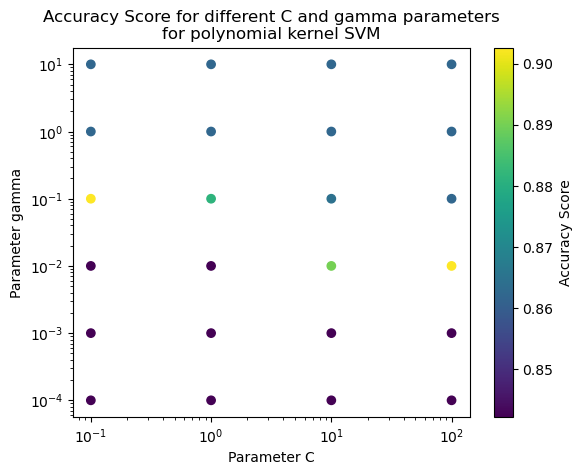

Best parameters:
C = 0.1
gamma = 0.1
Accuracy: 90.27%


In [ ]:
fig, ax = plt.subplots()

scatter = plt.scatter(cv_results_poly['param_C'], cv_results_poly['param_gamma'], c=cv_results_poly['mean_test_score'])

plt.xlabel('Parameter C')
plt.ylabel('Parameter gamma')
plt.title('Accuracy Score for different C and gamma parameters\nfor polynomial kernel SVM')
ax.set_xscale('log')
ax.set_yscale('log')
fig.colorbar(scatter).set_label('Accuracy Score')

plt.show()

print('Best parameters:\n' + 'C = ' + str(cv_results_poly.loc[cv_results_poly['mean_test_score'].idxmax()]['param_C']) + 
                             '\ngamma = ' +  str(cv_results_poly.loc[cv_results_poly['mean_test_score'].idxmax()]['param_gamma']) + 
                             '\nAccuracy: ' + str(round(cv_results_poly['mean_test_score'].max()*100,2)) + '%')

In [ ]:
# Compute the best polynomial kernel SVM
best_poly_C = cv_results_poly['params'][np.argmax(cv_results_poly['mean_test_score'])]['C']
best_poly_gamma = cv_results_poly['params'][np.argmax(cv_results_poly['mean_test_score'])]['gamma']
svm_best_poly = SVC(C=best_poly_C, gamma=best_poly_gamma, kernel='poly', probability=True)

# Fit the model to the training data
svm_best_poly.fit(X_train, y_train)

# Store the necessary variables for ROC/AUC
cols_to_store = [i for i in range(len(svm_best_poly.classes_)) if svm_best_poly.classes_[i] == 1]
y_svm_best_poly_pred = svm_best_poly.predict_proba(X_test)[:,cols_to_store]
y_svm_best_poly_true = (y_test.copy() == 1).copy()

In [ ]:
# Select the optimal C and gamma parameters by cross-validation for RBF kernel
tuned_parameters = [{'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
svm_rbf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy')
svm_rbf.fit(X_train, y_train)

cv_results_rbf = pd.DataFrame(svm_rbf.cv_results_)

# Takes around 7min to compute

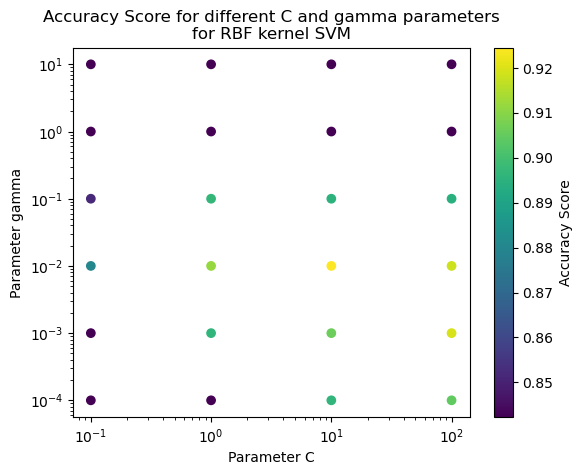

Best parameters:
C = 10
gamma = 0.01
Accuracy: 92.45%


In [ ]:
fig, ax = plt.subplots()

scatter = plt.scatter(cv_results_rbf['param_C'], cv_results_rbf['param_gamma'], c=cv_results_rbf['mean_test_score'])

plt.xlabel('Parameter C')
plt.ylabel('Parameter gamma')
plt.title('Accuracy Score for different C and gamma parameters\nfor RBF kernel SVM')
ax.set_xscale('log')
ax.set_yscale('log')
fig.colorbar(scatter).set_label('Accuracy Score')

plt.show()

print('Best parameters:\n' + 'C = ' + str(cv_results_rbf.loc[cv_results_rbf['mean_test_score'].idxmax()]['param_C']) + 
                             '\ngamma = ' +  str(cv_results_rbf.loc[cv_results_rbf['mean_test_score'].idxmax()]['param_gamma']) +
                             '\nAccuracy: ' + str(round(cv_results_rbf['mean_test_score'].max()*100,2)) + '%')

In [ ]:
# Compute the best RBF kernel SVM
best_rbf_C = cv_results_rbf['params'][np.argmax(cv_results_rbf['mean_test_score'])]['C']
best_rbf_gamma = cv_results_rbf['params'][np.argmax(cv_results_rbf['mean_test_score'])]['gamma']
svm_best_rbf = SVC(C=best_rbf_C, gamma=best_rbf_gamma, kernel='rbf', probability=True)

# Fit the model to the training data
svm_best_rbf.fit(X_train, y_train)

# Store the necessary variables for ROC/AUC
cols_to_store = [i for i in range(len(svm_best_rbf.classes_)) if svm_best_rbf.classes_[i] == 1]
y_svm_best_rbf_pred = svm_best_rbf.predict_proba(X_test)[:,cols_to_store]
y_svm_best_rbf_true = (y_test.copy() == 1).copy()

In [ ]:
# Select the optimal C and gamma parameters by cross-validation for sigmoid kernel
tuned_parameters = [{'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
svm_sigmoid = GridSearchCV(SVC(kernel='sigmoid'), tuned_parameters, cv=10, scoring='accuracy')
svm_sigmoid.fit(X_train, y_train)

cv_results_sigmoid = pd.DataFrame(svm_sigmoid.cv_results_)

# Takes around 3min to compute

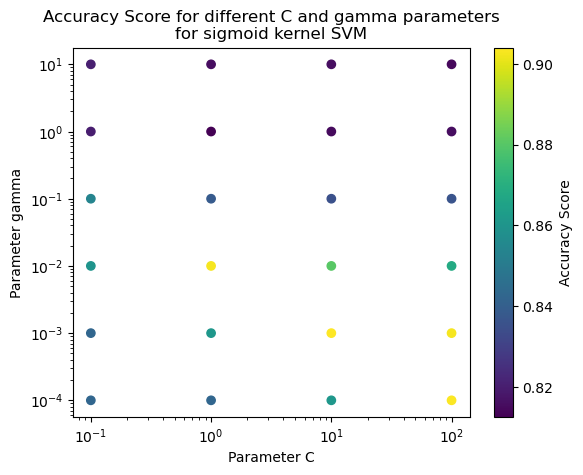

Best parameters:
C = 10
gamma = 0.001
Accuracy: 90.41%


In [ ]:
fig, ax = plt.subplots()

scatter = plt.scatter(cv_results_sigmoid['param_C'], cv_results_sigmoid['param_gamma'], c=cv_results_sigmoid['mean_test_score'])

plt.xlabel('Parameter C')
plt.ylabel('Parameter gamma')
plt.title('Accuracy Score for different C and gamma parameters\nfor sigmoid kernel SVM')
ax.set_xscale('log')
ax.set_yscale('log')
fig.colorbar(scatter).set_label('Accuracy Score')

plt.show()

print('Best parameters:\n' + 'C = ' + str(cv_results_sigmoid.loc[cv_results_sigmoid['mean_test_score'].idxmax()]['param_C']) + 
                             '\ngamma = ' +  str(cv_results_sigmoid.loc[cv_results_sigmoid['mean_test_score'].idxmax()]['param_gamma']) +
                             '\nAccuracy: ' + str(round(cv_results_sigmoid['mean_test_score'].max()*100,2)) + '%')

In [ ]:
# Compute the best sigmoid kernel SVM
best_sigmoid_C = cv_results_sigmoid['params'][np.argmax(cv_results_sigmoid['mean_test_score'])]['C']
best_sigmoid_gamma = cv_results_sigmoid['params'][np.argmax(cv_results_sigmoid['mean_test_score'])]['gamma']
svm_best_sigmoid = SVC(C=best_sigmoid_C, gamma=best_sigmoid_gamma, kernel='sigmoid', probability=True)

# Fit the model to the training data
svm_best_sigmoid.fit(X_train, y_train)

# Store the necessary variables for ROC/AUC
cols_to_store = [i for i in range(len(svm_best_sigmoid.classes_)) if svm_best_sigmoid.classes_[i] == 1]
y_svm_best_sigmoid_pred = svm_best_sigmoid.predict_proba(X_test)[:,cols_to_store]
y_svm_best_sigmoid_true = (y_test.copy() == 1).copy()

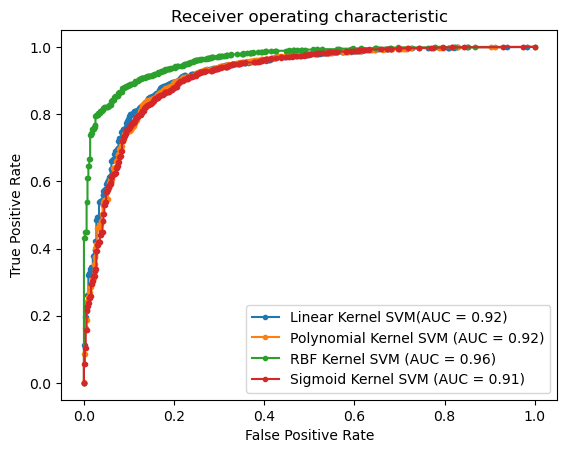

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_fpr, lr_tpr, _ = roc_curve(y_svm_best_linear_true, y_svm_best_linear_pred)
lr_fpr1, lr_tpr1, _ = roc_curve(y_svm_best_poly_true, y_svm_best_poly_pred)
lr_fpr2, lr_tpr2, _ = roc_curve(y_svm_best_rbf_true, y_svm_best_rbf_pred)
lr_fpr3, lr_tpr3, _ = roc_curve(y_svm_best_sigmoid_true, y_svm_best_sigmoid_pred)

plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Linear Kernel SVM(AUC = ' + str(np.round(roc_auc_score(y_svm_best_linear_true, y_svm_best_linear_pred),2)) + ')')
plt.plot(lr_fpr1, lr_tpr1, marker='.', label = 'Polynomial Kernel SVM (AUC = ' + str(np.round(roc_auc_score(y_svm_best_poly_true, y_svm_best_poly_pred),2)) + ')')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label = 'RBF Kernel SVM (AUC = ' + str(np.round(roc_auc_score(y_svm_best_rbf_true, y_svm_best_rbf_pred),2)) + ')')
plt.plot(lr_fpr3, lr_tpr3, marker='.', label = 'Sigmoid Kernel SVM (AUC = ' + str(np.round(roc_auc_score(y_svm_best_sigmoid_true, y_svm_best_sigmoid_pred),2)) + ')')

# Axis Labels
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()